Assuming the ratings of a review are classes, can we run TF-IDF on the text versus the ratings?

In [1]:
import json

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

print plt.style.available
plt.style.use('ggplot')

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [2]:
# --------------------------------------------- #
def fnShowNumberOfReviews(MOVIES):
    s = 0
    for m in MOVIES:
        if 'reviews' in m:
            # print m['name'], len(m['reviews'])
            s += len(m['reviews'])
        else:
            continue

    return s
    # --------------------------------------------- #

In [3]:
MOVIES = json.load(open('../../data-blog---list_of_movies_v2-v650.json','r'))

print 'We have {} movies in the dataset.'.format(len(MOVIES))
print '\nNumber of reviews available: {}'.format(fnShowNumberOfReviews(MOVIES))

We have 9869 movies in the dataset.

Number of reviews available: 436623


In [4]:
print MOVIES[0].keys()

[u'director', u'description', u'num_reviews_pages', u'reviews', u'stars', u'link', u'poster_desc', u'year', u'poster_img', u'name']


In [5]:
REVIEWS = []

for movie in MOVIES:
    if 'reviews' in movie:
        reviews_tmp = []
        for r in movie['reviews']:
            r['movie'] = movie['name']
            r['link'] = movie['link']
            reviews_tmp.append(r)
        REVIEWS += reviews_tmp
    else:
        continue
        
print len(REVIEWS)
print json.dumps(REVIEWS[3],indent=4)

436623
{
    "movie": "Pulp Fiction", 
    "review_content": "\nPulp Fiction may be the single best film ever made, and quite\nappropriately it is by one of the most creative directors of all time,\nQuentin Tarantino. This movie is amazing from the beginning definition\nof pulp to the end credits and boasts one of the best casts ever\nassembled with the likes of Bruce Willis, Samuel L. Jackson, John\nTravolta, Uma Thurman, Harvey Keitel, Tim Roth and Christopher Walken.\nThe dialog is surprisingly humorous for this type of film, and I think\nthat's what has made it so successful. Wrongfully denied the many\nOscars it was nominated for, Pulp Fiction is by far the best film of\nthe 90s and no Tarantino film has surpassed the quality of this movie\n(although Kill Bill came close). As far as I'm concerned this is the\ntop film of all-time and definitely deserves a watch if you haven't\nseen it.\n", 
    "review_rating": 10, 
    "review_title": "Unbelievable.", 
    "link": "/title/tt01109

In [6]:
data = pd.DataFrame(REVIEWS)

print data.head(2)

                link         movie  \
0  /title/tt0110912/  Pulp Fiction   
1  /title/tt0110912/  Pulp Fiction   

                                      review_content  review_rating  \
0  \nOne of the early scenes in "Pulp Fiction" fe...             10   
1  \nTo put this in context, I am 34 years old an...             10   

                        review_title         user_href  \
0  The masterpiece without a message  /user/ur0556667/   
1                    Simply The Best  /user/ur1515595/   

                   user_name  
0  kylopod (kylopod@aol.com)  
1                  wolvesrug  


In [7]:
# Lets not hold massive objects in memory.
MOVIES = REVIEWS = None

---
### Select Sub-set

Since the dataset is to big...

In [8]:
print data.review_rating.value_counts()
print '\n', np.sum(data.review_rating.isnull())

data.review_rating.fillna(0, inplace=True)

10    99088
8     52668
9     51853
7     40920
1     32887
6     28687
5     21950
4     16749
3     15982
2     13226
Name: review_rating, dtype: int64

62613


In [9]:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
from sklearn.cross_validation import StratifiedShuffleSplit

ixs = StratifiedShuffleSplit(data.review_rating.values, n_iter=1, test_size=0.98, train_size=None, random_state=None)

print len(ixs)
train_ix, test_ix = [(i[0],i[1]) for i in ixs ][0]
print len(train_ix), len(test_ix)
ixs = None

1
8733 427890


---
### Tokenizing Text

Using the standard NLTK Tokenize and some extra functions.
<br/>
<br/>

In [10]:
import re

from nltk import word_tokenize
from nltk.corpus import reuters 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
cachedStopWords = stopwords.words("english")

print len(cachedStopWords), cachedStopWords

127 [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor

In [12]:
# Define the tokenize function.
def tokenize(text):
    # Define the min-length for a word. We will disregard all words under min-length.
    min_length = 3
    # Use NLTK Tokenize and convert everything to lowercase.
    words = map(lambda word: word.lower(), word_tokenize(text))
    # Remove all stopwords from the text by using NLTK Stopwords.
    words = [word for word in words if word not in cachedStopWords]
    # Stem the words using NLTK PorterStemmer.
    #tokens = (list(map(lambda token: PorterStemmer().stem(token), words)))
    tokens = [PorterStemmer().stem(w) for w in words] 
    # Filter out words based on characters and length.
    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token)>=min_length, tokens))
    # Done, return the list.
    return filtered_tokens


text = data.ix[3].review_content
print text
print 'NLTK Tokenize: \n{}'.format(word_tokenize(text))
print '\nCustom Tokenize: \n{}'.format(tokenize(text))


Pulp Fiction may be the single best film ever made, and quite
appropriately it is by one of the most creative directors of all time,
Quentin Tarantino. This movie is amazing from the beginning definition
of pulp to the end credits and boasts one of the best casts ever
assembled with the likes of Bruce Willis, Samuel L. Jackson, John
Travolta, Uma Thurman, Harvey Keitel, Tim Roth and Christopher Walken.
The dialog is surprisingly humorous for this type of film, and I think
that's what has made it so successful. Wrongfully denied the many
Oscars it was nominated for, Pulp Fiction is by far the best film of
the 90s and no Tarantino film has surpassed the quality of this movie
(although Kill Bill came close). As far as I'm concerned this is the
top film of all-time and definitely deserves a watch if you haven't
seen it.

NLTK Tokenize: 
[u'Pulp', u'Fiction', u'may', u'be', u'the', u'single', u'best', u'film', u'ever', u'made', u',', u'and', u'quite', u'appropriately', u'it', u'is', u'by',

---
### TF-IDF

To classify the document we are using **TF-IDF**.

*[...] short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to **reflect how important a word is to a document** in a collection or corpus. It is **often used as a weighting factor in information retrieval and text mining**. The tf-idf value increases proportionally to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.*

Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification.* [Tf-Idf Wikipedia](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<br/>
<br/>

In [13]:
representer = TfidfVectorizer(
    tokenizer=tokenize, # Our custom tokenize function
    min_df=3, # The feature needs to be present in at least 3 documents
    max_df=0.90, # The feature cannot be in more than 90% of the documents.
    max_features=5000,  # Top 5000 features.
    use_idf=True, # Use IDF
    sublinear_tf=True # Use log-TF
)

%time representer.fit(data.ix[train_ix].review_content.values)

CPU times: user 52.3 s, sys: 514 ms, total: 52.8 s
Wall time: 53 s


TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=5000, min_df=3,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=True,
        token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x141d29b18>, use_idf=True,
        vocabulary=None)

In [14]:
# Get all the features from the trained representer.
all_features = representer.get_feature_names()

print len(all_features)
print all_features[:20]

5000
[u'a-team', u'a.k.a', u'aaron', u'abandon', u'abe', u'abil', u'abl', u'aboard', u'abraham', u'abrupt', u'absenc', u'absent', u'absolut', u'absorb', u'absurd', u'abund', u'abus', u'academi', u'accent', u'accept']


---
### Cosine Similarity

http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

print 'Review:', data.ix[3].review_content,
print 'Rating:', data.ix[3].review_rating
print 'Tf-idf:', representer.transform(data.ix[3].review_content).shape
print '\n\nReview:', data.ix[4].review_content,
print 'Rating:', data.ix[4].review_rating
print 'Tf-idf:', representer.transform(data.ix[4].review_content).shape

dist = 1.0 - cosine_similarity(representer.transform(data.ix[3:4].review_content))

print '\n\nDistance between the two: ', dist[1,0]

Review: 
Pulp Fiction may be the single best film ever made, and quite
appropriately it is by one of the most creative directors of all time,
Quentin Tarantino. This movie is amazing from the beginning definition
of pulp to the end credits and boasts one of the best casts ever
assembled with the likes of Bruce Willis, Samuel L. Jackson, John
Travolta, Uma Thurman, Harvey Keitel, Tim Roth and Christopher Walken.
The dialog is surprisingly humorous for this type of film, and I think
that's what has made it so successful. Wrongfully denied the many
Oscars it was nominated for, Pulp Fiction is by far the best film of
the 90s and no Tarantino film has surpassed the quality of this movie
(although Kill Bill came close). As far as I'm concerned this is the
top film of all-time and definitely deserves a watch if you haven't
seen it.
Rating: 10.0
Tf-idf: (829, 5000)


Review: 
Viewers are taken on a ride through three different stories that
entertwine together around the world of Marcellus Wall

In [16]:
# For the whole train-set we'll need to sort the matrix by rating, movie
train = data.ix[train_ix].copy()

train.sort(columns=['review_rating','movie'], inplace=True)

%time X = representer.transform(train.review_content)

# Calculate the symmetric distance matrix
%time X_dist = 1.0 - cosine_similarity(X)

X = None

CPU times: user 51.4 s, sys: 523 ms, total: 51.9 s
Wall time: 52.1 s


/Users/luuk/pyEnv/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


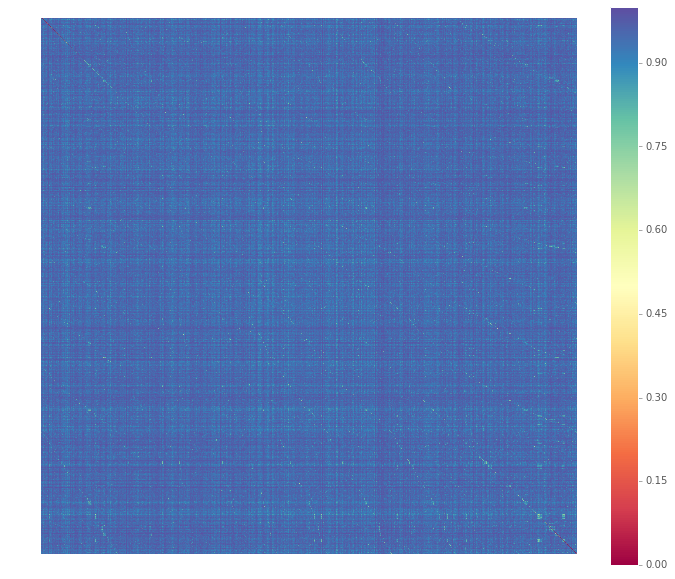

In [18]:
plt.figure(figsize=(12,10))
heatmap = plt.imshow(X_dist)
heatmap.set_cmap('Spectral') # .set_cmap('jet')
plt.colorbar()
plt.axis('off')
pass